In [718]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import math


In [38]:
device = torch.device("mps")

In [3]:
df = pd.read_csv('../data/30_yr_stock_market_data.csv')


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [616]:
print(df.columns.tolist())


['Dow Jones (^DJI)', 'Nasdaq (^IXIC)', 'S&P500 (^GSPC)', 'NYSE Composite (^NYA)', 'Russell 2000 (^RUT)', 'CBOE Volitility (^VIX)', 'DAX Index (^GDAXI)', 'FTSE 100 (^FTSE)', 'Hang Seng Index (^HSI)', 'Cocoa (CC=F)', 'Coffee (KC=F)', 'Corn (ZC=F)', 'Cotton (CT=F)', 'Live Cattle (LE=F)', 'Orange Juice (OJ=F)', 'Soybeans (ZS=F)', 'Sugar (SB=F)', 'Wheat (ZW=F)', 'Ethanol (EH=F)', 'Heating Oil (HO=F)', 'Natural Gas (NG=F)', 'Crude Oil-Brent (BZ=F)', 'Crude Oil-WTI (CL=F)', 'Copper (HG=F)', 'Gold (GC=F)', 'Palladium (PA=F)', 'Platinum (PL=F)', 'Silver (SI=F)', 'Treasury Yield 5 Years (^FVX)', 'Treasury Bill 13 Week (^IRX)', 'Treasury Yield 10 Years (^TNX)', 'Treasury Yield 30 Years (^TYX)']


In [880]:
dow_jones = df["Dow Jones (^DJI)"]
# Forward fill the missing values
dow_jones = dow_jones.ffill()

# Optionally, you can also backfill any remaining NaNs
dow_jones = dow_jones.bfill()


In [881]:
print(dow_jones.describe())



count     7754.000000
mean     14881.339203
std       8515.834197
min       3593.350098
25%       9474.327393
50%      11341.364746
75%      18084.122070
max      36799.648438
Name: Dow Jones (^DJI), dtype: float64


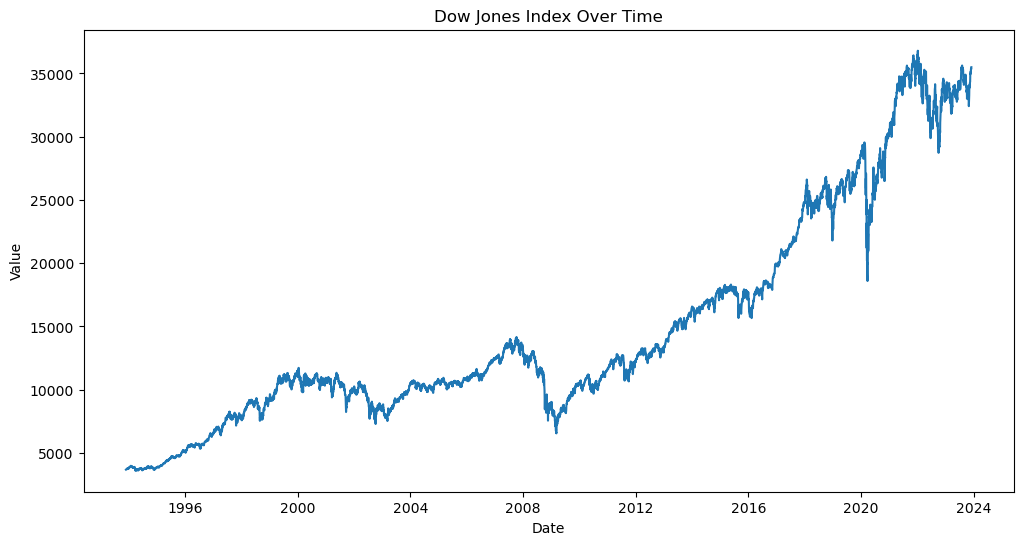

In [882]:
plt.figure(figsize=(12,6))
plt.plot(dow_jones)
plt.title('Dow Jones Index Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [883]:
# Reshape data for scaling
dow_jones_values = dow_jones.values.reshape(-1, 1)


In [884]:
dow_jones_values[:5]



array([[3677.80004883],
       [3683.94995117],
       [3697.08007812],
       [3702.11010742],
       [3704.07006836]])

In [912]:
def calculate_log_returns(data):
    return np.log(data[1:] / data[:-1])

def create_sequences(data, seq_length):
    xs = []
    ys = []
    initial_prices = []  # Store the initial price of each sequence

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        initial_price = x[0]  # Store the initial price

        log_returns_x = calculate_log_returns(x)
        log_returns_y = calculate_log_returns(np.array([x[-1], y]))[0][0]

        xs.append(log_returns_x)
        ys.append(log_returns_y)
        initial_prices.append(initial_price)

    return np.array(xs).reshape(-1,seq_length-1), np.array(ys), np.array(initial_prices).reshape(-1, 1)

def invert_log_returns(initial_price, log_returns):
    prices = [initial_price]
    for log_return in log_returns:
        prices.append(prices[-1] * np.exp(log_return))
    return np.array(prices)

def inverse_sequences(normalized_data, initial_prices):
    original_data = []
    for i in range(len(normalized_data)):
        original_sequence = invert_log_returns(initial_prices[i], normalized_data[i])
        original_data.append(original_sequence)
    return np.array(original_data)

def inverse_output(outputs, initial_prices):
    original_data = []
    for i in range(len(outputs)):
        inversed = initial_prices[i] * np.exp(outputs[i])
        original_data.append(inversed)
    return np.array(original_data)

    


seq_length = 30
# Create sequences
X, y, start_values = create_sequences(dow_jones_values, seq_length)



In [886]:
X[:5], y[:5]

(array([[ 0.00167077,  0.00355781,  0.00135962,  0.00052928,  0.00165623,
          0.00233405,  0.00419947, -0.00127272,  0.00291546,  0.00633172,
         -0.0058079 , -0.00689319,  0.00247747,  0.00680162,  0.00096976,
         -0.00268256,  0.00453958, -0.00118884,  0.        ,  0.00932641,
          0.00022146,  0.00014761, -0.00487443, -0.0057875 ,  0.00066838,
          0.00724088,  0.00393531,  0.00133106,  0.00443041],
        [ 0.00355781,  0.00135962,  0.00052928,  0.00165623,  0.00233405,
          0.00419947, -0.00127272,  0.00291546,  0.00633172, -0.0058079 ,
         -0.00689319,  0.00247747,  0.00680162,  0.00096976, -0.00268256,
          0.00453958, -0.00118884,  0.        ,  0.00932641,  0.00022146,
          0.00014761, -0.00487443, -0.0057875 ,  0.00066838,  0.00724088,
          0.00393531,  0.00133106,  0.00443041,  0.01164165],
        [ 0.00135962,  0.00052928,  0.00165623,  0.00233405,  0.00419947,
         -0.00127272,  0.00291546,  0.00633172, -0.0058079 , -

In [887]:
# Split the data
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.15)

# Split the normalized data and start values
X_train, y_train, start_values_train = X[:train_size], y[:train_size], start_values[:train_size]
X_val, y_val, start_values_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size], start_values[train_size:train_size + validation_size]
X_test, y_test, start_values_test = X[train_size + validation_size:], y[train_size + validation_size:], start_values[train_size + validation_size:]


In [888]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
start_values_train = torch.tensor(start_values_train).float()
X_val, y_val = torch.tensor(X_val).float(), torch.tensor(y_val).float()
start_values_val = torch.tensor(start_values_val).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()
start_values_test = torch.tensor(start_values_test).float()


In [889]:
X_train[:3], y_train[:3]

(tensor([[ 0.0017,  0.0036,  0.0014,  0.0005,  0.0017,  0.0023,  0.0042, -0.0013,
           0.0029,  0.0063, -0.0058, -0.0069,  0.0025,  0.0068,  0.0010, -0.0027,
           0.0045, -0.0012,  0.0000,  0.0093,  0.0002,  0.0001, -0.0049, -0.0058,
           0.0007,  0.0072,  0.0039,  0.0013,  0.0044],
         [ 0.0036,  0.0014,  0.0005,  0.0017,  0.0023,  0.0042, -0.0013,  0.0029,
           0.0063, -0.0058, -0.0069,  0.0025,  0.0068,  0.0010, -0.0027,  0.0045,
          -0.0012,  0.0000,  0.0093,  0.0002,  0.0001, -0.0049, -0.0058,  0.0007,
           0.0072,  0.0039,  0.0013,  0.0044,  0.0116],
         [ 0.0014,  0.0005,  0.0017,  0.0023,  0.0042, -0.0013,  0.0029,  0.0063,
          -0.0058, -0.0069,  0.0025,  0.0068,  0.0010, -0.0027,  0.0045, -0.0012,
           0.0000,  0.0093,  0.0002,  0.0001, -0.0049, -0.0058,  0.0007,  0.0072,
           0.0039,  0.0013,  0.0044,  0.0116, -0.0039]]),
 tensor([ 0.0116, -0.0039, -0.0004]))

In [890]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class SimpleTransformer(nn.Module):
    def __init__(self, input_size=30, num_layers=1, num_heads=4, dim_feedforward=64,
                 output_size=1, dropout=0, layer_norm_epsilon=1e-4, layers_to_hook=None):
        super(SimpleTransformer, self).__init__()

        # Each price is a scalar, map it to a high-dimensional space
        self.embedding = nn.Linear(1, dim_feedforward)
        self.pos_encoder = PositionalEncoding(dim_feedforward)

        transformer_layer = nn.TransformerEncoderLayer(
            d_model=dim_feedforward, 
            nhead=num_heads, 
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            #TODO: layer_norm_eps=layer_norm_epsilon
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.linear = nn.Linear(dim_feedforward, output_size)


        # Store activations and hooks
        self.activations = {}
        self.hooks = []

        # Layers to hook
        self.layers_to_hook = layers_to_hook if layers_to_hook is not None else []

        # Automatically register hooks
        self.register_hooks()

    def forward(self, src):
        src = src.unsqueeze(-1)  # Add feature dimension
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.linear(output[:, -1, :])  # Assuming you want the output based on the last time step
        return output


    def save_activation(self, name):
        def hook(model, input, output):
            if name == 'lstm':
                output_tensor = output[0]
            else:
                output_tensor = output
            self.activations[name] = output_tensor.detach().cpu().numpy().flatten()
        return hook

    def register_hooks(self):
        # Register hooks for specified layers
        for layer_name in self.layers_to_hook:
            layer = getattr(self, layer_name, None)
            if layer is not None:
                handle = layer.register_forward_hook(self.save_activation(layer_name))
                self.hooks.append(handle)

    def remove_hooks(self):
        # Remove all registered hooks
        for handle in self.hooks:
            handle.remove()
        self.hooks = []

# Example usage
activation_layers=[]
model = SimpleTransformer()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [891]:
parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(parameter_count)


25409


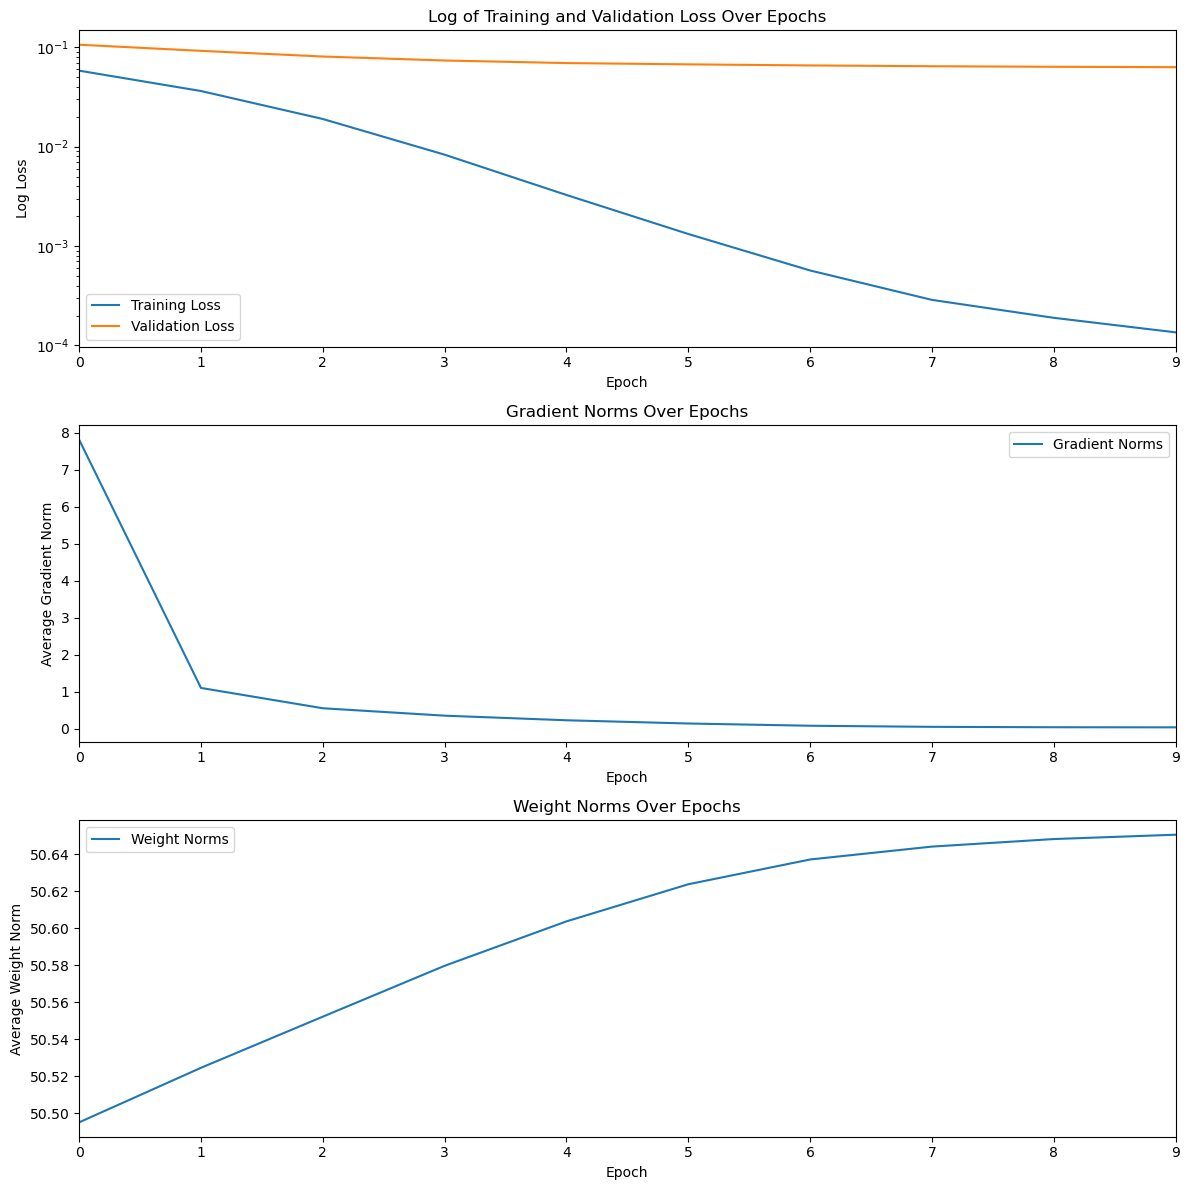

Epoch 10/10, Training Loss: 0.00013552, Validation Loss: 0.06294723


In [892]:
# Training settings
epochs = 10
batch_size = 128  # You can adjust this based on your dataset size and memory constraints

# Function to create mini-batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size].to(device)
        y_batch = y[i:i + batch_size].to(device)
        yield X_batch, y_batch
        

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Define the number of bins for the histogram
num_bins = 20

# Initialize a data structure to store activations for each epoch
activation_histograms = {layer: [] for layer in activation_layers}

gradient_norms = []
weight_norms = []

# Training loop
for epoch in range(epochs):
    # Dictionary to store activations for the epoch, for each layer
    epoch_activations = {layer: [] for layer in activation_layers}
    epoch_gradient_norms = []
    epoch_weight_norms = []

    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        # Move batch to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        assert outputs.shape[1] == 1, f"Output shape is not correct: {outputs.shape}"
        loss = criterion(outputs, y_batch)

        # Store activations for each layer
        for layer in activation_layers:
            activations = model.activations[layer]
            epoch_activations[layer].append(np.abs(activations))


        # Backward pass
        loss.backward()

        # Calculate and store gradient norms
        grad_norm = sum(p.grad.data.norm(2).item() for p in model.parameters() if p.grad is not None)
        epoch_gradient_norms.append(grad_norm)

        # Update weights
        optimizer.step()

        # Calculate and store weight norms
        weight_norm = sum(p.data.norm(2).item() for p in model.parameters())
        epoch_weight_norms.append(weight_norm)

    # Store the losses
    train_losses.append(loss.item())
    # Store average gradient and weight norms for the epoch
    gradient_norms.append(np.mean(epoch_gradient_norms))
    weight_norms.append(np.mean(epoch_weight_norms))
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val.to(device))
        val_loss = criterion(val_predictions, y_val.to(device))
    val_losses.append(val_loss.item())
    model.train()

    # Process activations to compute the histogram for the current epoch
    for layer in activation_layers:
        activations = np.hstack(epoch_activations[layer])
        counts, _ = np.histogram(activations, bins=num_bins, density=True)
        activation_histograms[layer].append(counts)

    # Clear the current figure
    display.clear_output(wait=True)

    # Plotting
    num_plots = len(activation_layers) + 3  # Additional plots for loss and norms
    fig, axs = plt.subplots(num_plots, 1, figsize=(12, 4*num_plots))

    plot_idx = 0  # Variable to keep track of the subplot index

    # Activation histogram for each layer
    for layer in activation_layers:
        hist_array = np.array(activation_histograms[layer])
        max_count = hist_array.max()

        for bin_idx in range(num_bins):
            normalized_counts = hist_array[:, bin_idx] / max_count
            colors = 1.0 - normalized_counts
            axs[plot_idx].bar(range(epoch + 1), hist_array[:, bin_idx], bottom=np.sum(hist_array[:, :bin_idx], axis=1),
                              color=[f'{c}' for c in colors], edgecolor='grey')

        axs[plot_idx].set_title(f'{layer.capitalize()} Activation Histogram')
        axs[plot_idx].set_xlabel('Epoch')
        axs[plot_idx].set_ylabel('Normalized Activation Frequency')
        axs[plot_idx].set_xlim(0, epochs - 1)

        plot_idx += 1  # Increment the subplot index


    # Loss plot with logarithmic scale
    axs[plot_idx].plot(train_losses, label='Training Loss')
    axs[plot_idx].plot(val_losses, label='Validation Loss')
    axs[plot_idx].set_title('Log of Training and Validation Loss Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].set_ylabel('Log Loss')
    axs[plot_idx].set_yscale('log')  # Set the y-axis to a logarithmic scale
    axs[plot_idx].legend()
    plot_idx+=1

    # Gradient norms plot
    axs[plot_idx].plot(gradient_norms, label='Gradient Norms')
    axs[plot_idx].set_title('Gradient Norms Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_ylabel('Average Gradient Norm')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].legend()
    plot_idx+=1

    # Weight norms plot
    axs[plot_idx].plot(weight_norms, label='Weight Norms')
    axs[plot_idx].set_title('Weight Norms Over Epochs')
    axs[plot_idx].set_xlabel('Epoch')
    axs[plot_idx].set_ylabel('Average Weight Norm')
    axs[plot_idx].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[plot_idx].legend()

    plt.tight_layout()
    plt.show()

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.8f}, Validation Loss: {val_losses[-1]:.8f}')



In [893]:
#exemple layer outputs
with torch.no_grad():
    src = X_val[:1].to(device)
    print(src)
    src = src.unsqueeze(-1)  # Add feature dimension
    embedding = getattr(model, "embedding")
    src = embedding(src)
    print(src)
    pos_encoder = getattr(model, "pos_encoder")
    src = pos_encoder(src)
    print(src)


tensor([[-1.8505e-03,  1.2942e-02,  1.1282e-02, -1.3971e-03,  1.0129e-03,
          5.7754e-03,  3.9922e-03,  1.1079e-03,  2.2628e-03,  6.5864e-05,
         -1.5336e-04,  2.3020e-03, -1.0230e-03,  7.3746e-04,  2.2680e-03,
         -1.1816e-04,  1.8794e-03,  5.1260e-03,  4.4009e-04, -1.6619e-04,
          7.1883e-04,  0.0000e+00,  2.7498e-05, -2.8894e-03,  5.7634e-03,
          1.8478e-03, -6.9917e-04,  3.2734e-03, -5.9372e-03]], device='mps:0')
tensor([[[-0.0514,  0.5502, -0.8364,  ...,  0.6380,  0.2068, -0.3754],
         [-0.0527,  0.5594, -0.8497,  ...,  0.6359,  0.2201, -0.3784],
         [-0.0526,  0.5584, -0.8482,  ...,  0.6361,  0.2187, -0.3781],
         ...,
         [-0.0515,  0.5509, -0.8374,  ...,  0.6378,  0.2079, -0.3756],
         [-0.0518,  0.5534, -0.8410,  ...,  0.6373,  0.2115, -0.3764],
         [-0.0510,  0.5477, -0.8327,  ...,  0.6386,  0.2032, -0.3745]]],
       device='mps:0')
tensor([[[-0.0514,  1.5502, -0.8364,  ...,  1.6380,  0.2068,  0.6246],
         [-0.05

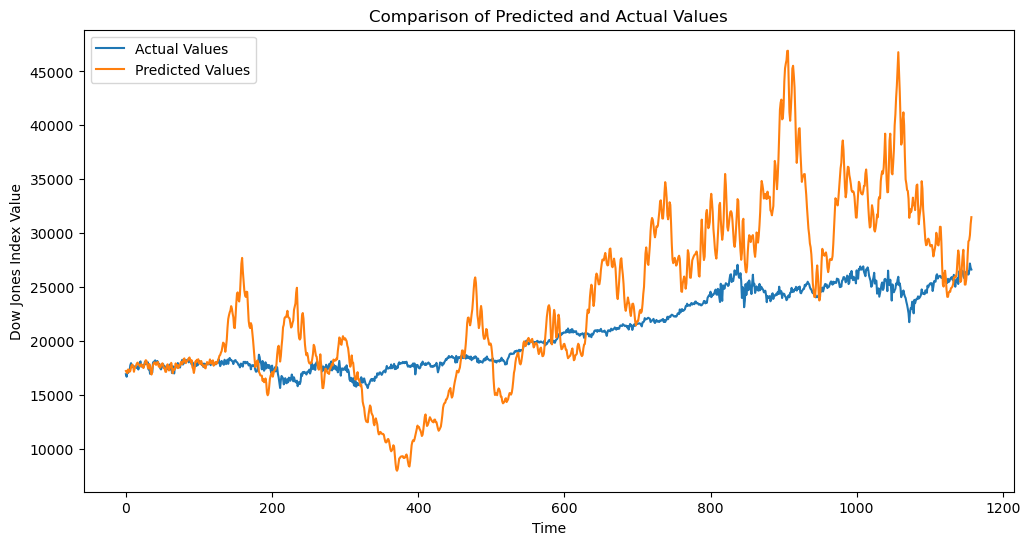

In [913]:
# Expand or unsqueeze start_values_val to match val_predictions shape
start_values_expanded = start_values_val.unsqueeze(1)  # shape becomes [batch_size, 1]

# Perform element-wise multiplication and addition
#val_predictions_inverse = (val_predictions.cpu() * start_values_expanded.cpu()) + start_values_expanded.cpu()
val_predictions_inverse = inverse_output(val_predictions.cpu().numpy(), start_values_val)


# Since the actuals (y_val) are already the next value and not a sequence, we can use them directly
val_actuals = y_val.cpu().numpy()
#val_actuals_inverse = (val_actuals * start_values_val.numpy()) + start_values_val.numpy()
val_actuals_inverse = inverse_output(val_actuals, start_values_val)

# Plotting
plt.figure(figsize=(12,6))
# Make sure to use the flatten method to convert arrays to 1D for plotting
plt.plot(val_actuals_inverse, label='Actual Values')
plt.plot(val_predictions_inverse, label='Predicted Values')
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')
plt.legend()
plt.show()

In [911]:
val_predictions
val_predictions_inverse
print(val_actuals[0])
print(start_values_val[0])
print(val_predictions[0])



-0.0028766335
tensor([17005.7500])
tensor([0.0145], device='mps:0')


In [ ]:
actual_changes = np.diff(val_actuals_inverse.flatten()) >= 0
predicted_changes = np.diff(val_predictions_inverse.flatten()) >= 0

correct_direction = actual_changes == predicted_changes

# Number of bins
num_bins = 50

# Calculate the length of each bin
bin_length = len(correct_direction) // num_bins

# Plot the actual values
plt.figure(figsize=(15, 7))
plt.plot(val_actuals_inverse.flatten(), label='Actual Values', color='gray')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')

# Create a secondary y-axis for percentages
ax2 = plt.twinx()

# Calculate the percentage of correct predictions for each bin
bin_percentages = []
for i in range(0, len(correct_direction), bin_length):
    bin_correct = correct_direction[i:i + bin_length]
    bin_percentage = np.sum(bin_correct) / len(bin_correct) * 100
    bin_percentages.append(bin_percentage)

# Plot the bin percentages
ax2.bar(range(0, len(correct_direction), bin_length), bin_percentages, 
        width=bin_length, alpha=0.3, color='green', label='Directional Accuracy (%)')
ax2.set_ylabel('Percentage Correct (%)')
ax2.set_ylim(0, 100)  # Set y-axis limits for percentages
ax2.axhline(50, color='red', linestyle='--', linewidth=1)

# Add legend
plt.title('Dow Jones Index Values and Directional Accuracy Over Time')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
model_mse = mean_squared_error(val_actuals_inverse, val_predictions_inverse)
print(f"Model Validation MSE: {model_mse:.4f}")
print(f"Directional Accuracy: {np.sum(correct_direction)/len(correct_direction) * 100:.2f}%")


Rolling Mean Model Validation MSE: 369057.5854
Rolling Mean Model Directional Accuracy: 52.70%

LSTM, 10 epochs, 10 seq_len, 41301 parameters
LSTM Model Validation MSE: 433850.3750
LSTM Directional Accuracy: 52.16%

with normalisation of sequences:
LSTM, 25 epochs, 10 seq_len, 41301 parameters
LSTM Model Validation MSE: 33822.5195
LSTM Directional Accuracy: 50.00%

same but 50 epochs and 100 seq_len:
Model Validation MSE: 34161.9648
Directional Accuracy: 49.78%
after more than about 45 epochs the validation loss starts going up

50 epochs(overfit a bit), 100 seq_len but 2 layers of lstm:
Model Validation MSE: 47159.7578
Directional Accuracy: 49.96%

same but with 0.1 dropout(very bad overfit, validation never went down):
Model Validation MSE: 863093.9375
Directional Accuracy: 49.43%

same but no dropout but 0.0001 weight decay:
Model Validation MSE: 77646.6094
Directional Accuracy: 51.53%

same but 0.00001 weight decay:
Model Validation MSE: 46377.8867
Directional Accuracy: 51.00%

same decay but 160 epochs:
Model Validation MSE: 41197.1562
Directional Accuracy: 50.22%

0.000005 decay 200 epochs, then doesn't get much better with time:
Model Validation MSE: 35292.2344
Directional Accuracy: 50.13%

0.000001 weight decay and 50 epochs, can overfit, not enough regularization:
Model Validation MSE: 46218.1797
Directional Accuracy: 50.13%

0.000005 decay and 1 layer 50 epochs:
Model Validation MSE: 36054.2383
Directional Accuracy: 49.96%

same but x2 decay 100 epochs:
Model Validation MSE: 34878.0469
Directional Accuracy: 50.04%

same but 200 hidden layer and 50 epochs:
Model Validation MSE: 36013.7500
Directional Accuracy: 49.96%
